In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import vits, melgan, hifigan
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from malaya_speech.train.loss import calculate_2d_loss, calculate_3d_loss

In [5]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
config = vits.Config(mel = 80, vocabs = 66)

In [8]:
model = vits.Model(config)

In [9]:
i = tf.convert_to_tensor([data['text_ids'][0],data['text_ids'][0]])
i_lengths = tf.convert_to_tensor([data['len_text_ids'][0,0], data['len_text_ids'][0,0]])
mel_outputs = tf.convert_to_tensor([data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]])
mel_lengths = tf.convert_to_tensor([408,408])
wavs = tf.convert_to_tensor([wav['wav'].astype(np.float32)] * 2)[:,0]
wavs.shape

TensorShape([Dimension(2), Dimension(104448)])

In [10]:
# i = tf.placeholder(tf.int32, [None, None])
# i_lengths = tf.placeholder(tf.int32, [None])
# mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
# mel_lengths = tf.placeholder(tf.int32, [None])

In [11]:
hifigan_config = malaya_speech.config.hifigan_config
generator = hifigan.Generator(
    hifigan.GeneratorConfig(**hifigan_config['hifigan_generator_params']),
    name='hifigan_generator',
)
multiperiod_discriminator = hifigan.MultiPeriodDiscriminator(
    hifigan.DiscriminatorConfig(
        **hifigan_config['hifigan_discriminator_params']
    ),
    name='hifigan_multiperiod_discriminator',
)
multiscale_discriminator = melgan.MultiScaleDiscriminator(
    melgan.DiscriminatorConfig(
        **hifigan_config['melgan_discriminator_params'],
        name='melgan_multiscale_discriminator',
    )
)
discriminator = hifigan.Discriminator(
    multiperiod_discriminator, multiscale_discriminator
)

In [12]:
losses, attn, latent, z_slice, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
losses

{'kl': <tf.Tensor: id=41561, shape=(), dtype=float32, numpy=1.3556324>,
 'durloss': <tf.Tensor: id=41760, shape=(), dtype=float32, numpy=0.88549703>}

In [14]:
y_hat = generator(z_slice, training = True)
y_hat.shape

TensorShape([Dimension(2), Dimension(8192), Dimension(1)])

In [15]:
z_slice.shape

TensorShape([Dimension(2), Dimension(32), Dimension(80)])

In [16]:
mel = vits.slice_segments(mel_outputs, ids_slice, model.segment_size // model.hop_size, np.log(1e-2))
mel

<tf.Tensor: id=44959, shape=(2, 32, 80), dtype=float32, numpy=
array([[[ 0.7531843 ,  0.76587594,  0.09148856, ..., -1.341348  ,
         -1.1416262 , -1.312505  ],
        [ 0.7546218 ,  0.8032181 ,  0.19947359, ..., -0.71938163,
         -0.55812013, -0.7046082 ],
        [ 0.7117106 ,  0.819191  ,  0.48339272, ...,  0.36781716,
          0.4005598 ,  0.4677347 ],
        ...,
        [-0.515803  , -0.66888416,  0.42710364, ...,  0.50325733,
          0.44044077,  0.25710905],
        [-0.80711514, -1.0972444 ,  0.35110876, ...,  0.40204278,
          0.6744475 ,  0.2717947 ],
        [-0.78009987, -0.8366035 ,  0.4458518 , ...,  0.31994513,
          0.55779994,  0.13321659]],

       [[ 0.15459907,  1.032958  ,  1.1411421 , ...,  0.3080847 ,
          0.22114256,  0.12326591],
        [ 0.19377448,  1.0525615 ,  1.1386122 , ..., -0.14439853,
         -0.22759637, -0.29042798],
        [ 0.08384158,  1.0445338 ,  1.1898142 , ..., -1.0895917 ,
         -0.9534814 , -0.5794527 ],
    

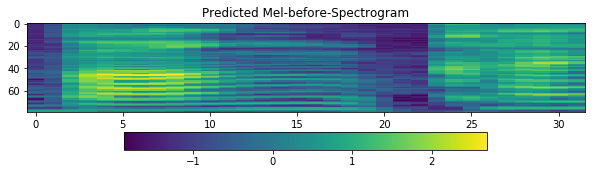

In [17]:
mel_outputs_ = np.reshape(mel[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

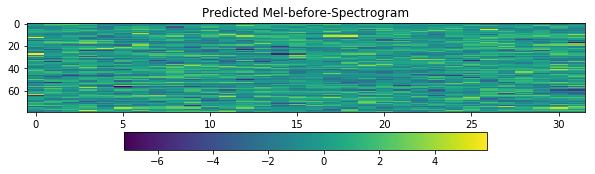

In [18]:
mel_outputs_ = np.reshape(z_slice[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [19]:
y = vits.slice_segments(tf.expand_dims(wavs, -1), ids_slice * model.hop_size, model.segment_size)
y.shape

TensorShape([Dimension(2), Dimension(8192), Dimension(1)])

In [20]:
y.shape, y_hat.shape

(TensorShape([Dimension(2), Dimension(8192), Dimension(1)]),
 TensorShape([Dimension(2), Dimension(8192), Dimension(1)]))

In [21]:
mels_loss = melgan.loss.TFMelSpectrogram()
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [ ]:
p = discriminator(y)
p_hat = discriminator(y_hat)

In [ ]:
calculate_2d_loss(tf.squeeze(y, -1), tf.squeeze(y_hat, -1), loss_fn=mels_loss)

In [ ]:
calculate_3d_loss(mel, z_slice, loss_fn=mae_loss)

In [ ]:
real_loss = 0.0
fake_loss = 0.0
for i in range(len(p)):
    real_loss += calculate_3d_loss(
        tf.ones_like(p[i][-1]), p[i][-1], loss_fn=mse_loss
    )
    fake_loss += calculate_3d_loss(
        tf.zeros_like(p_hat[i][-1]), p_hat[i][-1], loss_fn=mse_loss
    )
real_loss /= i + 1
fake_loss /= i + 1
dis_loss = real_loss + fake_loss

In [ ]:
mae_loss = tf.keras.losses.MeanAbsoluteError()

# p = discriminator(y)
# p_hat = discriminator(y_hat)

# adv_loss = 0.0
# for i in range(len(p_hat)):
#     adv_loss += calculate_3d_loss(
#         tf.ones_like(p_hat[i][-1]), p_hat[i][-1], loss_fn=mse_loss
#     )
# adv_loss /= i + 1

# fm_loss = 0.0
# for i in range(len(p_hat)):
#     for j in range(len(p_hat[i]) - 1):
#         fm_loss += calculate_3d_loss(
#             p[i][j], p_hat[i][j], loss_fn=mae_loss
#         )

# fm_loss /= (i + 1) * (j + 1)
# adv_loss += 1.0 * fm_loss
# generator_loss = 1.0 * adv_loss

mel_loss = calculate_3d_loss(mel, z_slice, loss_fn=mae_loss)
mel_loss

In [ ]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

In [ ]:
# optimizer = tf.train.AdamOptimizer(learning_rate = 1e-6, beta1 = 0.9, 
#                                    beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9)

In [ ]:
for k in range(100):
    with tf.GradientTape() as tape:
        losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
        mel = vits.slice_segments(mel_outputs, ids_slice, model.segment_size // model.hop_size, np.log(1e-2))
        mel_loss = calculate_3d_loss(mel, mel_hat, loss_fn=mae_loss)
        loss = losses['nll'] + losses['durloss'] + mel_loss
    print(k, losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

In [ ]:
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

In [ ]:
# %%time

# o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                                mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})

In [ ]:
# o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                         mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})
# o[1]

In [ ]:
# for k in range(50):
#     o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                                mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})
#     print(k, o)

In [ ]:
# o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                         mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})

In [ ]:
mel_outputs_ = np.reshape(mel_[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')